In [26]:
#importing required libraries
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk
import os
import sys

# Loading Class Labels

In [27]:
# Split all the classes by a new line and store it in variable called rows
classes = open('E:\DS and ML Projects\Object Detection Using yolo and open cv\coco.names').read().strip().split("\n")

# Check the number of classes
print("Number of classes: {}\n".format(len(classes)))

print(classes)

Number of classes: 80

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# Read the image 

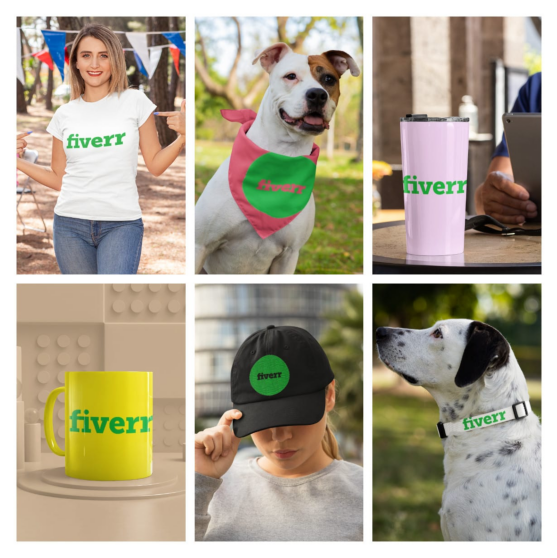

In [28]:
# Load the image
image = cv2.imread("E:\DS and ML Projects\Object Detection Using yolo and open cv\sample image.jpg")

# Display image
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1]);plt.axis("off");

# Initializing DNN Module

In [29]:
# Load YOLO weights
weights = "E:\DS and ML Projects\Object Detection Using yolo and open cv\yolov3.weights"

# Load configuration architecture
cfg_arshitecture = "E:\DS and ML Projects\Object Detection Using yolo and open cv\yolov3.cfg"

# Initialize network
net = cv2.dnn.readNetFromDarknet(cfg_arshitecture, weights)

In [30]:
# Get the layer names of the architecture
layer_names = net.getLayerNames()
print("Number of layers in the network {}".format(len(layer_names)))

Number of layers in the network 254


In [31]:
output_layers = [layer_names[idx[0]-1] for idx in net.getUnconnectedOutLayers()]
print(output_layers)

['yolo_82', 'yolo_94', 'yolo_106']


# Pre Processing the image

In [32]:
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416,416), swapRB = True, crop = False)

# Input the Blob image to the Network 

In [33]:
# Passing the blob as input through the network
net.setInput(blob)

# Forward Pass

In [34]:
%%time
outputs = net.forward(output_layers)

Wall time: 1.07 s


In [35]:
# Generate Random color list
(h,w) = image.shape[:2]
colors = np.random.randint(50, 255, size=(len(classes),3), dtype = "uint8")

# Post Process the results

In [36]:
# We'll store all the bounding boxes, confidence and class_indexes here
BOXES = [] # it will contain bounding box coordinates of the object
CONF = [] # it will contain confidence probability of the object
CLASS_INDEX = [] # it will contain the index of the object

conf = 0.5

# iterate for each output layer
for output in outputs:
    # iterate for each detection in that output layer
    for detection in output:
        # Get the probabilities of all classes for that detection
        scores = detection[5:]
        # Get the class id of the most likely class
        classID = np.argmax(scores)
        # Get the confidence
        confidence = scores[classID]
        # Make sure that the confidence is greater than some threshold
        if confidence > conf:
            
            # Multiply the relative coordinates with width and height to get the actual coordinates on the image
            box = detection[0:4] * np.array([w,h, w,h])
            # Convert to int
            (centerX, centerY, width, height) = box.astype("int")
            # Get x1, y1 from the center points
            x= int(centerX-(width/2))
            y= int(centerY-(height/2))
            
            # Add values in the lists created above
            BOXES.append([x, y, int(width), int(height)])
            CONF.append(float(confidence))
            CLASS_INDEX.append(classID)

In [37]:
print("Detected Objects: {}".format(len(CLASS_INDEX)))

Detected Objects: 14


# Non-Max Suppression

In [38]:
NMS = cv2.dnn.NMSBoxes(BOXES, CONF, conf, 0.4)

(-0.5, 1199.5, 1199.5, -0.5)

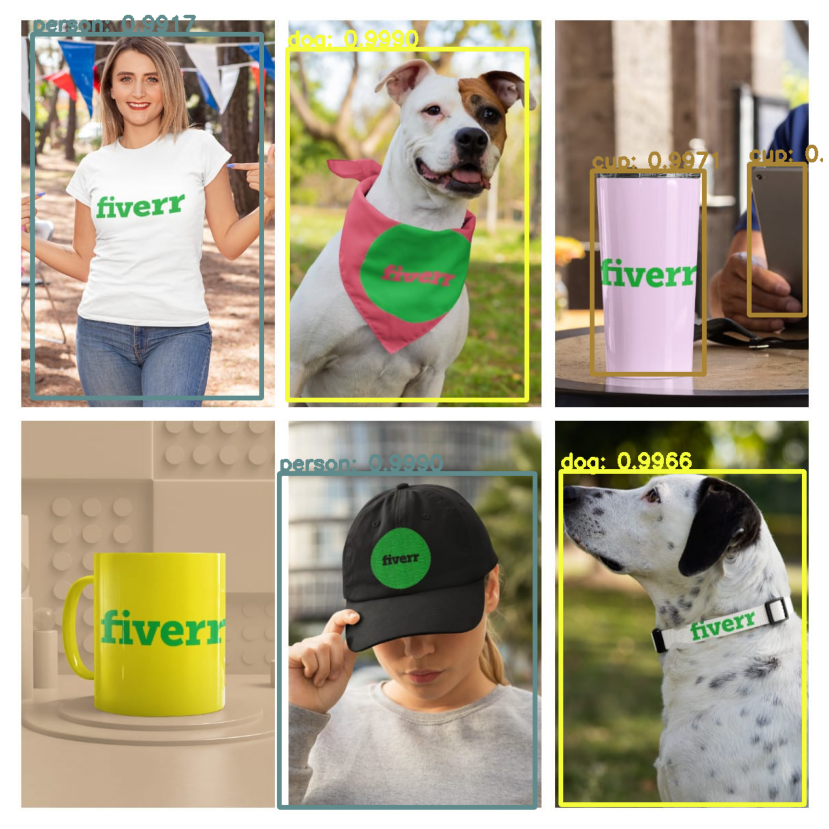

In [39]:
image_copy = image.copy()

# Proceed if detections exist
if len(NMS) > 0:
    # Loop over the valid indexes
    for i in NMS.flatten():
        # Extract the bounding box coordinates
        (X1, Y1) = (BOXES[i][0], BOXES[i][1])
        (width, height) = (BOXES[i][2], BOXES[i][3])
        # Draw a bounding box rectangle and label on the image
        color = [int(clr) for clr in colors[CLASS_INDEX[i]]]
        cv2.rectangle(image_copy, (X1,Y1), (X1 + width, Y1 + height), color, 6)
        
        text = "{}: {:.4f}".format(classes[CLASS_INDEX[i]], CONF[i])
        cv2.putText(image_copy, text, (X1, Y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

# Show the output image
plt.figure(figsize = (15,15))
plt.imshow(image_copy[:,:,::-1]);plt.axis("off")

# Creating Functions

In [40]:
def init_detect(usegpu = 'None' , weights_name = 'yolov3.weights', architecture_name = 'yolov3.cfg'):
    # Set Global variables
    global net, CLASSES, OUTPUT_LAYERS_NAME, COLORS
    
    base_path = 'E:\DS and ML Projects\Object Detection Using yolo and open cv'
    
    # Read the classes
    CLASSES = open(os.path.join(base_path, 'coco.names')).read().strip().split("\n")
    colors = np.random.randint(100, 255, size=(len(classes),3), dtype = "uint8")
    
    weights = os.path.join(base_path, weights_name)
    architecture = os.path.join(base_path, architecture_name)
    
    # Initialize the method
    net = cv2.dnn.readNetFromDarknet(architecture, weights)
    LIST_OF_LAYERS_NAME = net.getLayerNames()
    OUTPUT_LAYERS_NAME = [layer_names[idx[0]-1] for idx in net.getUnconnectedOutLayers()]
    
    if usegpu == 'cude':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

# Main Method

In [41]:
def yolo_detect(image = [] , usercam = False,  returndata = False, size=2, detect_thresh=0.5, nms_thresh=0.4, annotate='True'):
    
    # if user didn't specify image, then consider choosing file or camera snapshot
    if np.size(image) == 0:
        
        # if usercam is True, then take picture from camera
        if usercam:
            cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame = cap.read()
            if ret:
                image = cv2.flip(frame,1)
                cap.release()
            else:
                print("Can not open camera")
                sys.exit()
        # otherwise select image from computer using tkinter
        else:
            root = Tk()
            filename = filedialog.askopenfilename(title = "Select any Image")
            root.withdraw()
            image = cv2.imread(filename)
            
    
    
    (h,w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416,416), swapRB = True, crop = False)
    net.setInput(blob)
    outputs = net.forward(OUTPUT_LAYERS_NAME)
    
    # We'll store all the bounding boxes, confidence and class_indexes here
    BOXES = [] # it will contain bounding box coordinates of the object
    CONF = [] # it will contain confidence probability of the object
    CLASS_INDEX = [] # it will contain the index of the object
    
    image_copy = image.copy()
    (X1, Y1) = (BOXES[i][0], BOXES[i][1])
    (width, height) = (BOXES[i][2], BOXES[i][3])
     # Draw a bounding box rectangle and label on the image
    color = [int(clr) for clr in colors[CLASS_INDEX[i]]]
    cv2.rectangle(image_copy, (X1,Y1), (X1 + width, Y1 + height), color, 6)
        
    text = "{}: {:.4f}".format(classes[CLASS_INDEX[i]], CONF[i])
    cv2.putText(image_copy, text, (X1, Y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 4)
    
    if returndata:
        return image_copy
    else:
        plt.figure(figsize = (15,15))
        plt.imshow(image_copy[:,:,::-1]);plt.axis("off")


# Initialize the YOLO detector

In [42]:
init_detect()

# Calling detector with default arguments

In [43]:
image = cv2.imread("E:\DS and ML Projects\Object Detection Using yolo and open cv\minnion.jpg")
yolo_detect(image)

IndexError: list index out of range

In [25]:
image = cv2.imread("E:\DS and ML Projects\Object Detection Using yolo and open cv\ferrari.jpg")
yolo_detect(image)

AttributeError: 'NoneType' object has no attribute 'shape'

In [39]:
image = cv2.imread('E:\Machine Learning Projects\Object Detection Using yolo and open cv\ammunation.jpg')
yolo_detect(image)

AttributeError: 'NoneType' object has no attribute 'shape'

# Capturing image from camera

In [44]:
yolo_detect(usercam=True)

IndexError: list index out of range